In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# boilerplate code
from __future__ import print_function
import tensorflow as tf
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import os, sys, cv2
import argparse
import os.path as osp
import glob

from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

sys.path.append('/home/yfantaye/DeepCount/TFFRCNN')

from lib.networks.factory import get_network
from lib.fast_rcnn.config import cfg
from lib.fast_rcnn.test import im_detect
#from lib.fast_rcnn.nmms_wrapper import nms
from lib.utils.timer import Timer

%matplotlib inline

In [22]:
class parse_args():
    gpu_id=0
    cpu_mode=False
    demo_net='VGGnet_test'
    model='../unet_models/00/model.cpkt'
    model_sax25='../unet_models/40/model.cpkt'
    model_sax50='../unet_models/60/model.cpkt'
    
args = parse_args()
args.model

'../unet_models/00/model.cpkt'

In [26]:
#REF:
# https://blog.metaflow.fr/tensorflow-how-to-freeze-a-model-and-serve-it-with-a-python-api-d4f3596b3adc
# http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/

def get_graph(model_folder,node_names = "outputs",clear_devices = True):
    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    #absolute_model_folder = "/".join(input_checkpoint.split('/')[:-1])
    #output_graph = absolute_model_folder + "/frozen_model.pb"

    # Before exporting our graph, we need to precise what is our output node
    # This is how TF decides what part of the Graph he has to keep and what part it can dump
    # NOTE: this variable is plural, because you can have multiple output nodes
    

    # We clear devices to allow TensorFlow to control on which device it will load operations
    
    
    # We import the meta graph and retrieve a Saver
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

    # We retrieve the protobuf graph definition
    graph = tf.get_default_graph()
    input_graph_def = graph.as_graph_def()

    # We start a session and restore the graph weights
    with tf.Session() as sess:
        saver.restore(sess, input_checkpoint)

        # We use a built-in TF helper to export variables to constants
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            input_graph_def, # The graph_def is used to retrieve the nodes 
            node_names.split(",") # The output node names are used to select the usefull nodes
        ) 
        
    return output_graph_def

def freeze_graph(model_folder):
    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_folder = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_folder + "/frozen_model.pb"

    # Before exporting our graph, we need to precise what is our output node
    # This is how TF decides what part of the Graph he has to keep and what part it can dump
    # NOTE: this variable is plural, because you can have multiple output nodes
    output_node_names = "Accuracy/predictions"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True
    
    # We import the meta graph and retrieve a Saver
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

    # We retrieve the protobuf graph definition
    graph = tf.get_default_graph()
    input_graph_def = graph.as_graph_def()

    # We start a session and restore the graph weights
    with tf.Session() as sess:
        saver.restore(sess, input_checkpoint)

        # We use a built-in TF helper to export variables to constants
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            input_graph_def, # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
            
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we can use again a convenient built-in function to import a graph_def into the 
    # current default Graph
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(
            graph_def, 
            input_map=None, 
            return_elements=None, 
            name="prefix", 
            op_dict=None, 
            producer_op_list=None
        )
    return graph



def use_frozen_model(frozen_model_filename):
    # We use our "load_graph" function
    graph = load_graph(frozen_model_filename)

    # We can verify that we can access the list of operations in the graph
    for op in graph.get_operations():
        print(op.name)
        # prefix/Placeholder/inputs_placeholder
        # ...
        # prefix/Accuracy/predictions
        
    # We access the input and output nodes 
    x = graph.get_tensor_by_name('prefix/Placeholder/inputs_placeholder:0')
    y = graph.get_tensor_by_name('prefix/Accuracy/predictions:0')
        
    # We launch a Session
    with tf.Session(graph=graph) as sess:
        # Note: we didn't initialize/restore anything, everything is stored in the graph_def
        y_out = sess.run(y, feed_dict={
            x: [[3, 5, 7, 4, 5, 1, 1, 1, 1, 1]] # < 45
        })
        print(y_out) # [[ False ]] Yay, it works!

## Loading and displaying the model graph
The pretrained network can be downloaded here. Unpack the tensorflow_inception_graph.pb file from the archive and set its path to model_fn variable. Alternatively you can uncomment and run the following cell to download the network:

In [24]:

# creating TensorFlow session and loading the model
#graph = tf.Graph()
#sess = tf.InteractiveSession(graph=graph)
#with tf.gfile.FastGFile(model_fn, 'rb') as f:
#    graph_def = tf.GraphDef()
#    graph_def.ParseFromString(f.read())
#t_input = tf.placeholder(np.float32, name='input') # define the input tensor
#imagenet_mean = 117.0
#t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
#tf.import_graph_def(graph_def, {'input':t_preprocessed})



To take a glimpse into the kinds of patterns that the network learned to recognize, we will try to generate images that maximize the sum of activations of particular channel of a particular convolutional layer of the neural network. The network we explore contains many convolutional layers, each of which outputs tens to hundreds of feature channels, so we have plenty of patterns to explore.

In [9]:
# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## Naive feature visualization
Let's start with a naive way of visualizing these. Image-space gradient ascent!

In [11]:
# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
    clear_output()
    showarray(visstd(img))

#render_naive(T(layer)[:,:,:,channel])

In [12]:
def vis_detections(im, class_name, dets, ax, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                 fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""
    
    # Plotly
    #import visdom
    #import plotly.plotly as py
    #import plotly.tools as tls

    # Load the demo image
    im = cv2.imread(image_name)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')

    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, ax, thresh=CONF_THRESH)

    # Converting to Plotly's Figure object..
    #plotly_fig = tls.mpl_to_plotly(fig)
    #vis = visdom.Visdom()
    #vis._send(plotly_fig)    

def restore_model(model_folder,clear_devices = True):
    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_folder = "/".join(input_checkpoint.split('/')[:-1])
    #output_graph = absolute_model_folder + "/frozen_model.pb"

    # Before exporting our graph, we need to precise what is our output node
    # This is how TF decides what part of the Graph he has to keep and what part it can dump
    # NOTE: this variable is plural, because you can have multiple output nodes
    output_node_names = "Accuracy/predictions"

    # We clear devices to allow TensorFlow to control on which device it will load operations    
    # We import the meta graph and retrieve a Saver
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)    
        
    return saver, tf.get_default_graph() #{'sess':sess,'graph_def':input_graph_def,'graph':graph,'saver':saver}
    
def main():
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals

    args = parse_args()

    if args.model == ' ' or not os.path.exists(args.model):
        #print ('current path is ' + os.path.abspath(__file__))
        raise IOError(('Error: Model not found.\n'))

    # init session
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
    # load network
    net = get_network(args.demo_net)
    # load model
    print ('Loading network {:s}... '.format(args.demo_net)),
    saver = tf.train.Saver()
    saver.restore(sess, args.model)
    print (' done.')

    # Warmup on a dummy image
    im = 128 * np.ones((300, 300, 3), dtype=np.uint8)
    for i in xrange(2):
        _, _ = im_detect(sess, net, im)

    im_names = glob.glob(os.path.join(cfg.DATA_DIR, 'demo', '*.png')) + \
               glob.glob(os.path.join(cfg.DATA_DIR, 'demo', '*.jpg'))

    for im_name in im_names:
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('Demo for {:s}'.format(im_name))
        demo(sess, net, im_name)



Number of files used: 1
[[ 0.  0.]
 [ 0.  0.]]


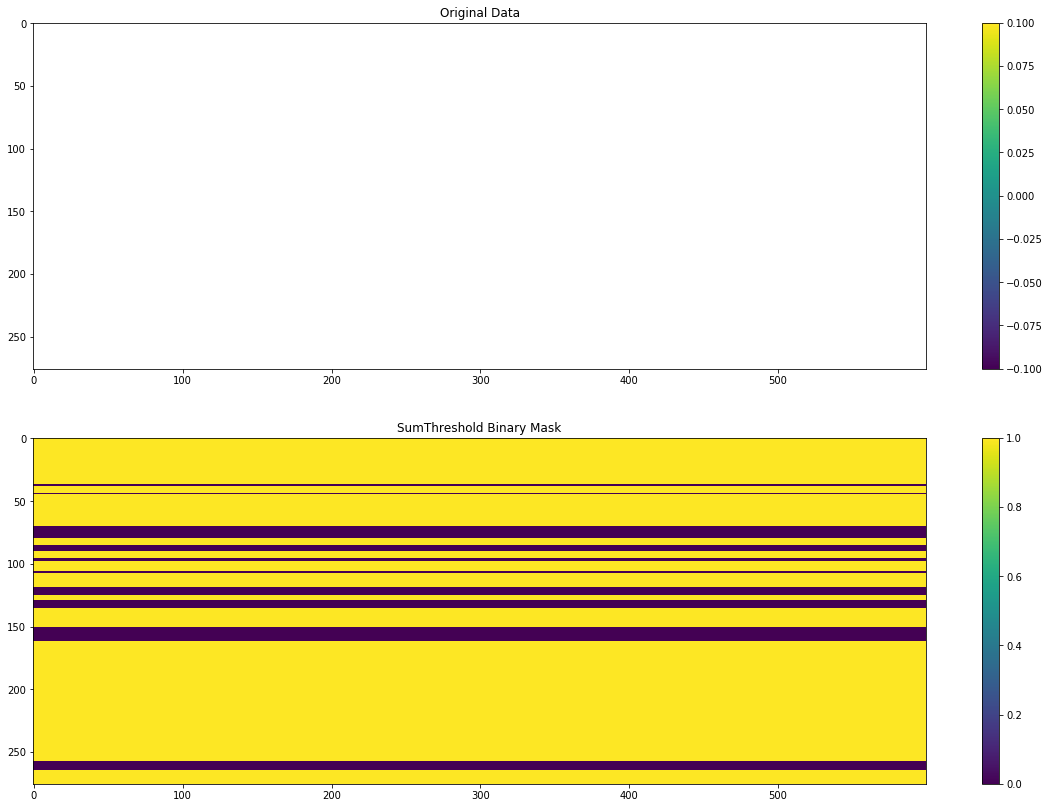

In [5]:
dsubdir='hide_sim_30days_seeked'
dsubdir='sax50'
data_dir='../data/'+dsubdir
files = glob.glob('{}/*20160302*'.format(data_dir))
data_provider = DataProvider(600, files)
x_test, y_test = data_provider(1)

fig, ax = plt.subplots(2,1, figsize=(20,14))
img=ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[0].set_title('Original Data')
plt.colorbar(img,ax=ax[0])

img=ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[1].set_title('SumThreshold Binary Mask')
plt.colorbar(img,ax=ax[1])


In [1]:
from unet_scripts.radio_util import DataProvider
from tf_unet import unet
import glob

dsubdir='hide_sim_30days_seeked'
dsubdir='sax50'
data_dir='../data/'+dsubdir
files = glob.glob('{}/*20160302*'.format(data_dir))
data_provider = DataProvider(600, files)

net = unet.Unet(channels=data_provider.channels, 
                n_class=data_provider.n_class, 
                layers=3, 
                features_root=64,
                cost_kwargs=dict(regularizer=0.001),
                )

model_path="../unet_model/{}/".format(dsubdir)
trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))

2017-09-29 13:01:18,630 Layers 3, features 64,    filter size 3x3,    pool size: 2x2


Number of files used: 1


In [2]:
path = trainer.train(data_provider, model_path, 
                     training_iters=32, 
                     epochs=1, 
                     dropout=0.5, 
                     display_step=2)

2017-09-29 13:01:22,517 Removing '/home/yfantaye/SETI/tf_unet/notebook/prediction'
2017-09-29 13:01:22,519 Removing '/home/yfantaye/SETI/tf_unet/unet_model/sax50'
2017-09-29 13:01:22,521 Allocating '/home/yfantaye/SETI/tf_unet/notebook/prediction'
2017-09-29 13:01:22,522 Allocating '/home/yfantaye/SETI/tf_unet/unet_model/sax50'
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tf_unet-0.1.0-py2.7.egg/tf_unet/image_util.py:78: RuntimeWarning: invalid value encountered in true_divide
  data /= np.amax(data)


[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]


2017-09-29 13:01:27,086 Verification error= 80.9%, loss= nan
/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tf_unet-0.1.0-py2.7.egg/tf_unet/util.py:74: RuntimeWarning: invalid value encountered in true_divide
  img /= np.amax(img)
2017-09-29 13:01:30,470 Start optimization


[[ 0.  0.]
 [ 0.  0.]]


InvalidArgumentError: Nan in summary histogram for: dw_convolution_00/activations
	 [[Node: dw_convolution_00/activations = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](dw_convolution_00/activations/tag, down_layers/relu0_2)]]

Caused by op u'dw_convolution_00/activations', defined at:
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-6a1064217445>", line 15, in <module>
    cost_kwargs=dict(regularizer=0.001),
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tf_unet-0.1.0-py2.7.egg/tf_unet/unet.py", line 216, in __init__
    **kwargs)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tf_unet-0.1.0-py2.7.egg/tf_unet/unet.py", line 171, in create_conv_net
    tf.summary.histogram("dw_convolution_%02d"%k + '/activations', dw_h_convs[k])
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/summary/summary.py", line 221, in histogram
    tag=scope.rstrip('/'), values=values, name=scope)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 131, in _histogram_summary
    name=name)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/yfantaye/anaconda3/envs/py27/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Nan in summary histogram for: dw_convolution_00/activations
	 [[Node: dw_convolution_00/activations = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](dw_convolution_00/activations/tag, down_layers/relu0_2)]]


In [13]:
data_provider = DataProvider(10000, files)
x_test, y_test = data_provider(1)
prediction = net.predict(path, x_test)

Number of files used: 1
INFO:tensorflow:Restoring parameters from ../unet_model/hideseek_sim_00/model.cpkt


2017-09-28 19:42:52,905 Restoring parameters from ../unet_model/hideseek_sim_00/model.cpkt
2017-09-28 19:42:53,112 Model restored from file: ../unet_model/hideseek_sim_00/model.cpkt


In [23]:
#prediction.shape
init = tf.global_variables_initializer()
with tf.Session() as sess:
    # Initialize variables                                                                                          
    sess.run(init)
    net.restore(sess,model_path)
    graph=sess.graph


ValueError: At least two variables have the same name: output/b

## Visualize test

In [13]:
print('orig shape: ',x_test.shape)
print('orig label shape: ',y_test.shape)
print('predict shape',prediction.shape)
#unet.util.plot_prediction(x_test[0,...,0], y_test[0,...,1], prediction[0,...,1])

orig shape:  (1, 276, 600, 1)
orig label shape:  (1, 276, 600, 2)
predict shape (1, 236, 560, 2)


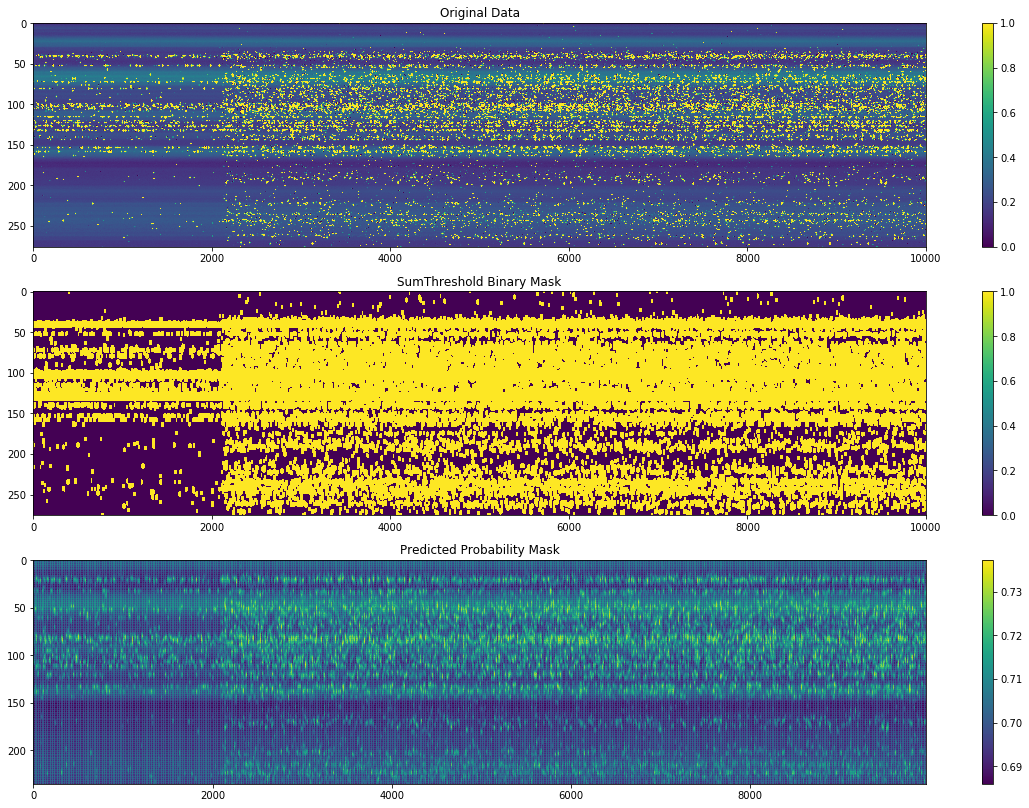

In [18]:
fig, ax = plt.subplots(3,1, figsize=(20,14))
img=ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[0].set_title('Original Data')
plt.colorbar(img,ax=ax[0])

img=ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[1].set_title('SumThreshold Binary Mask')
plt.colorbar(img,ax=ax[1])

img=ax[2].imshow(prediction[0,...,1], aspect="auto")
ax[2].set_title('Predicted Probability Mask')
plt.colorbar(img,ax=ax[2])

In [ ]:
fig, axx = plt.subplots(2,1,figsize=(20,12))
ax1=axx[0]
ax2=axx[1]
pp=prediction[0,...,1].copy()
pp[pp>pp.mean()]=1.0
pp[pp<pp.mean()]=0.0
img=ax1.imshow(pp, aspect="auto")
ax1.set_title('Predicted Probability Mask')

img=ax2.imshow(y_test[0,...,1], aspect="auto")
ax2.set_title('SumThreshold Binary Mask')
plt.colorbar(img,ax=2)
#plt.colorbar(img,ax=ax1)

## Tensorboard

In [25]:
# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
nnames=['trainable_variables', 'variables', 'train_op', 'summaries']
graph=get_graph(model_path,output_nodes=','.join(nnames))

tmp_def = rename_nodes(graph, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def,max_const_size=10)

TypeError: get_graph() got an unexpected keyword argument 'output_nodes'

In [16]:
print('get_all_collection_keys',graph.get_all_collection_keys())
print('get_name_scope',graph.get_name_scope())

layers = [op.name for op in graph.get_operations() if op.name=='div' ]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print(layers)
print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

get_all_collection_keys ['trainable_variables', 'variables', 'train_op', 'summaries']
get_name_scope 
[]
Number of layers 0
Total number of feature channels: 0


In [20]:
path

'../unet_model/hideseek_sim_00/model.cpkt'